In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
#DATA_DIR = '/storage/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
#DATA_VERSION = 'april21'
#RESULTS_DIR = '/storage/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
DATA_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_VERSION = 'oct22'
RESULTS_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
SHAM = True

########################################################################################
sham_str = '_wSham' if SHAM else ''

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import pandas as pd
import scanpy as sc
from util import pcr, upsample_underrepresented
import itertools
from tqdm.notebook import tqdm
import json
from pathlib import Path

from matplotlib.text import Text
import matplotlib.patches as patches

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 150
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Load data

In [20]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')

In [21]:
adata.n_obs

147082

In [4]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')
adata = adata[adata.obs["region"] != "Scapula"]

# Variance Explained by PC Regression

Principle: We have a dataset with several celltypes and two conditions (e.g. Naive vs MCAO OR regions e.g. Skull vs all other bones). We want to assess how strong Naive cells vs MCAO cells differ within each celltype (wrt their expressions). Such that we have a relativ measure to asses wich celltypes are affected stronger by the condition.    
As a metric we calculate the variance explained (pc regression) with covariate "condition". It gives a relative value: ratio of variance explained within agiven cell type. Could have also been interesting to compare instead the total variance explained. Cell types with low variance in general might have large values just due to noise in the relative setting...

# function for systematic pc regressions of interest

Here we have code for sequential runs of the PC regression, however it's recommended to use the `scripts/pcregr.sh` 
script for parallelized computation. This notebook is mainly for the plots that follow after the pc regression cells.

In [6]:
def pc_regressions(data,celltype,ct_key='cell_types',conditions="all",regions="all",uniform=False,n_comps=50,min_cells=20):
    """Run all pcr regressions we're interested in for one celltype
    
    uniform: bool
        Set this to False, first thought that would be important for weighting the samples. Instead this introduces a wrong
        "sample info weighting".
    """
    
    if conditions == "all":
        conditions = data.obs['condition'].unique().tolist()
    if regions == "all":
        regions = data.obs['region'].unique().tolist()
    
    results = {
        'full_set': dict({'condition':np.nan,'region':np.nan}, **{r:np.nan for r in regions}),
        'comb_subsets': {f'{comb[0]}_{comb[1]}':np.nan for comb in itertools.combinations(conditions,2)},
        'cond_subsets': {cond:{} for cond in conditions}
    }
    results_pval = {
        'full_set': dict({'condition':np.nan,'region':np.nan}, **{r:np.nan for r in regions}),
        'comb_subsets': {f'{comb[0]}_{comb[1]}':np.nan for comb in itertools.combinations(conditions,2)},
        'cond_subsets': {cond:{} for cond in conditions}
    }    
    
    iterations = (2+len(regions))
    iterations+= len([comb for comb in itertools.combinations(conditions,2)]) if (len(conditions) > 2) else 0
    iterations+= len(conditions) * (1+len(regions))
    pbar = tqdm(total=iterations)
        
    adata = data[data.obs[ct_key] == celltype].copy()
    
    # initialize covariates
    for r in regions:
        adata.obs[r] = 'other'
        adata.obs.loc[adata.obs['region'] == r,r] = r
    
    ###############################
    # regressions on full dataset #
    ###############################
    # - covariate = conditions (all conditions at once)
    # - covariate = regions:
    #    - all regions at once
    #    - one region vs all others (n_regions times)
    if not uniform:
        a = adata.copy()
        if a.n_obs > min_cells:
            if ('X_pca' in a.obsm): del a.obsm['X_pca']
            if ('PCs' in a.varm): del a.varm['PCs']
            if ('pca' in a.uns): del a.uns['pca']            
            sc.tl.pca(a, n_comps=min(n_comps,a.n_obs-1), svd_solver='arpack', use_highly_variable=False)
        
    if (a.n_obs > min_cells) and (a.obs['condition'].value_counts() > min_cells).all():
        if uniform:
            a = upsample_underrepresented(adata.copy(),'condition') 
        var_expl_and_pval = pcr(a,n_comps=n_comps,covariate='condition',verbose=False,recompute_pca=uniform)
        results['full_set']['condition'], results_pval['full_set']['condition'] = var_expl_and_pval
    else:
        results['full_set']['condition'] = np.nan
        results_pval['full_set']['condition'] = np.nan
    pbar.update()
    
    if (a.n_obs > min_cells) and (a.obs['region'].value_counts() > min_cells).all():
        if uniform:
            a = upsample_underrepresented(adata.copy(),'region')        
        var_expl_and_pval = pcr(a,n_comps=n_comps,covariate='region',verbose=False,recompute_pca=uniform)
        results['full_set']['region'], results_pval['full_set']['region'] = var_expl_and_pval
    else:
        results['full_set']['region'] = np.nan
        results_pval['full_set']['region'] = np.nan
    pbar.update()
    
    for r in regions:
        if (a.n_obs > min_cells) and (a.obs[r].value_counts() > min_cells).all():
            if uniform:
                a = upsample_underrepresented(adata.copy(),r)            
            var_expl_and_pval = pcr(a,n_comps=n_comps,covariate=r,verbose=False,recompute_pca=uniform)
            results['full_set'][r], results_pval['full_set'][r] = var_expl_and_pval
        else:
            results['full_set'][r] = np.nan
            results_pval['full_set'][r] = np.nan
        pbar.update()
    
    ######################################################
    # regress on each subset of 2 condition combinations #
    ###################################################### if number of conditions > 2
    if len(conditions) > 2:
        for comb in itertools.combinations(conditions, 2):
            a = adata[adata.obs['condition'].isin(comb)].copy()
            if (a.n_obs > min_cells) and (a.obs['condition'].value_counts() > min_cells).all():
                if uniform:
                    a = upsample_underrepresented(a,'condition')                
                var_expl_and_pval = pcr(a, n_comps=n_comps, covariate='condition', verbose=False, recompute_pca=True)
                results['comb_subsets'][f'{comb[0]}_{comb[1]}'], results_pval['comb_subsets'][f'{comb[0]}_{comb[1]}'] = var_expl_and_pval
            else:
                results['comb_subsets'][f'{comb[0]}_{comb[1]}'] = np.nan
                results_pval['comb_subsets'][f'{comb[0]}_{comb[1]}'] = np.nan
            pbar.update()
   
    ######################################
    # for each condition regress regions #
    ######################################
    for cond in conditions:
        a_cond = adata[adata.obs['condition'] == cond].copy()
        
        if not uniform:
            a = a_cond.copy()
            if a.n_obs > min_cells:
                if ('X_pca' in a.obsm): del a.obsm['X_pca']
                if ('PCs' in a.varm): del a.varm['PCs']
                if ('pca' in a.uns): del a.uns['pca']
                sc.tl.pca(a, n_comps=min(n_comps,a.n_obs-1), svd_solver='arpack', use_highly_variable=False)
        
        if (a.n_obs > min_cells) and (a.obs['region'].value_counts() > min_cells).all():
            if uniform:
                a = upsample_underrepresented(a_cond.copy(),'region')
            var_expl_and_pval = pcr(a,n_comps=n_comps,covariate='region',verbose=False,recompute_pca=uniform)
            results['cond_subsets'][cond]['region'], results_pval['cond_subsets'][cond]['region'] = var_expl_and_pval
        else:
            results['cond_subsets'][cond]['region'] = np.nan
            results_pval['cond_subsets'][cond]['region'] = np.nan
        pbar.update()
        
        for r in regions:
            if (a.n_obs > min_cells) and (a.obs[r].value_counts() > min_cells).all():            
                if uniform:
                    a = upsample_underrepresented(a_cond.copy(),r)
                var_expl_and_pval = pcr(a,n_comps=n_comps,covariate=r,verbose=False,recompute_pca=uniform)
                results['cond_subsets'][cond][r], results_pval['cond_subsets'][cond][r] = var_expl_and_pval
            else:
                results['cond_subsets'][cond][r] = np.nan
                results_pval['cond_subsets'][cond][r] = np.nan
            pbar.update()
        
    pbar.close()
    
    return results, results_pval

# Run regressions for all celltypes

In [ ]:
for CT_KEY in tqdm(['level1','level2']):  
    #cts = [ct for ct in adata.obs[CT_KEY].unique()]
    #cts = [ct for ct in adata.obs[CT_KEY].unique() if not os.path.isfile(results_dir+f'{ct}.json')]
    
    # THIS IS ACTUALLY FINE CODE; BUT NOT NEEDED RIGHT NOW!
    ## all regions (pool bones)
    #results_dir = RESULTS_DIR+f'pc_regression/{CT_KEY}/VS_bones_no_scapula/'
    #Path(results_dir).mkdir(parents=True, exist_ok=True)
    #cts = [ct for ct in adata.obs[CT_KEY].unique() if not os.path.isfile(results_dir+f'{ct}.json')]
    #a = adata.copy()
    #a.obs['region'] = a.obs['region'].astype(str)
    #a.obs.loc[~a.obs['region'].isin(['Brain','Meninges']),'region'] = 'Bones'    
    #for ct in tqdm(cts):
    #    if os.path.isfile(results_dir+f'{ct}.json') and os.path.isfile(results_dir+f'{ct}_pval.json'):
    #        continue
    #    results, results_pval = pc_regressions(a,ct,ct_key=CT_KEY,conditions="all",regions="all",uniform=False,n_comps=50,min_cells=20)
    #    with open(results_dir+f'{ct}.json', 'w') as file:
    #        json.dump(results, file)
    #    with open(results_dir+f'{ct}_pval.json', 'w') as file:
    #        json.dump(results_pval, file)
            
    # bones only
    results_dir = RESULTS_DIR+f'pc_regression/{CT_KEY}/bones_no_scapula/'
    Path(results_dir).mkdir(parents=True, exist_ok=True)
    cts = [ct for ct in adata.obs[CT_KEY].unique() if not os.path.isfile(results_dir+f'{ct}.json')]
    a = adata[~adata.obs['region'].isin(['Brain','Meninges'])].copy()
    for ct in tqdm(cts):
        if os.path.isfile(results_dir+f'{ct}.json') and os.path.isfile(results_dir+f'{ct}_pval.json'): # Ah this is already in cts! could be deleted here
            continue        
        results, results_pval = pc_regressions(a,ct,ct_key=CT_KEY,conditions="all",regions="all",uniform=False,n_comps=50,min_cells=20)
        with open(results_dir+f'{ct}.json', 'w') as file:
            json.dump(results, file)
        with open(results_dir+f'{ct}_pval.json', 'w') as file:
            json.dump(results_pval, file)            

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [31]:
results

{'full_set': {'condition': 0.15814596770310183,
  'region': 0.5488343578986684,
  'Skull': 0.4508898035961824,
  'Brain': 0.06556891647901505,
  'Meninges': 0.04576630004798713,
  'Pelvis': 0.2812899032828928},
 'comb_subsets': {'MCAO_Sham': 0.14068293493919778,
  'MCAO_Naive': 0.09311134975646518,
  'Sham_Naive': 0.18811804789004116},
 'cond_subsets': {'MCAO': {'region': 0.43295501911742873,
   'Skull': 0.4183298580098351,
   'Brain': 0.10742071954664652,
   'Meninges': 0.07386134397825589,
   'Pelvis': 5.01175797555202e-09},
  'Sham': {'region': 0.6334971948750412,
   'Skull': 2.811125050048001e-08,
   'Brain': 0.6334971948750412,
   'Meninges': 0.6334971948750412,
   'Pelvis': 2.811125050048001e-08},
  'Naive': {'region': 0.7381008833556767,
   'Skull': 3.726407034259418e-09,
   'Brain': 0.47388458868682565,
   'Meninges': 0.31989815334373894,
   'Pelvis': 0.4792225949901783}}}

# Plots (including permutation pval)

In [7]:
def get_region_df(results_dir,cts,results_key='full_set',bones_only=True,condition=None,exclude_nans=True):
    """Load df for bar_plot()
    
    results_key: This could be used to also support the condition specific region comparisons
                 but actually only "full_set" is supported so far since the condition specific
                 results have one more level in the nested dict.
    condition:
        We also calculated region pcrs for each condition subset. Define to plot for a given
        condition instead of all conditions pooled. Set results_key to 'cond_subsets' otherwise condition
        does not work.
    """
    
    if bones_only:
        regions = ['Skull','Vertebra','Humerus','Femur','Pelvis']        
        #regions = ['Skull','Vertebra','Scapula','Humerus','Femur','Pelvis']
    else:
        regions = ['Brain','Meninges','Bones']

    
    n_regions = len(regions)#8
    #n_conds = 3
    n_cts = len(cts)
    
    df = pd.DataFrame(index=[i for i in range(n_regions*n_cts)], columns=['celltype','region','score','pval'])
    
    row = 0
    for ct in cts:
        try:
            with open(results_dir+f'{ct}.json', 'r') as fp, open(results_dir+f'{ct}_pval.json', 'r') as fpval:
                tmp = json.load(fp)
                tmp2 = json.load(fpval)
                for r in regions:
                    if condition:
                        score = tmp[results_key][condition][r] if (r in tmp[results_key][condition]) else np.nan
                        pval = tmp2[results_key][condition][r] if (r in tmp2[results_key][condition]) else np.nan
                    else:
                        score = tmp[results_key][r] if (r in tmp[results_key]) else np.nan
                        pval = tmp2[results_key][r] if (r in tmp2[results_key]) else np.nan
                    df.loc[row,['celltype','region','score','pval']] = [ct,r,score,pval]
                    row += 1
        except:
            print(f"Couldn't load file {results_dir+f'{ct}.json'}")
    if exclude_nans:
        return df[(~df.isnull().any(axis=1)) & (~(df["score"]<0.000001))]
    else:
        return df

In [8]:
bones = ['Skull', 'Vertebra', 'Humerus', 'Femur', 'Pelvis']

In [9]:
cts = adata.obs['level1'].unique()
res_dir = RESULTS_DIR+f'pc_regression/level1/'
df = get_region_df(res_dir+"bones_no_scapula/",cts,results_key='full_set',bones_only=True,exclude_nans=False)

### different plot versions

- 3 plots in one
- each condition individually

- no additional threshold
- putting a R2Var threshold


In [10]:
def filter_celltypes_for_significance(df,pval_th=0.0001):
    """
    """
    df["sign"] = df["pval"] < pval_th
    n_sign = df.groupby("celltype")["sign"].sum()
    sign_cts = n_sign.loc[n_sign > 0].index.tolist()    
    return df.loc[df["celltype"].isin(sign_cts)]

def filter_celltypes_for_R2_th(df,R2_th=0.008):
    """
    """
    df["higher"] = df["score"] > R2_th
    n_higher = df.groupby("celltype")["higher"].sum()
    high_cts = n_higher.loc[n_higher > 0].index.tolist()
    return df.loc[df["celltype"].isin(high_cts)]

def get_ct_order(df):
    
    tmp = df.groupby("celltype")["score"].max()
    tmp = tmp.sort_values(ascending=False)
    
    return tmp.index.tolist()

In [11]:
def bar_plot(adata,df,hue='region',save=None,order=None,colors=None,pval_th=0.0001,legend_pos=1.9):
    """
    
    df: has columns ['celltype',hue,'score']
    hue: 'condition','region', or sth else - in that case provide order and colors!
    save: path to save plot
    """
    
    assert len(df["score"]) == len(df["score"].unique()), "This assertion is needed to find the correct bars when coloring by pval"
    # if this doesn't hold you could add some epsilon to the similar values
    
    # Rename Skull to Calvaria
    if (hue in adata.obs.columns) and ("Skull" in adata.obs[hue].cat.categories):
        adata.obs[hue].cat.rename_categories({'Skull': 'Calvaria'}, inplace=True)
    if "region" in df.columns:
        df.loc[df["region"] == "Skull","region"] = "Calvaria"
    if order is not None:
        order = ["Calvaria" if r=="Skull" else r for r in order]
    
    #try:
    if hue in ['condition','region']:
        if order is None:
            order = adata.obs[hue].cat.categories.values
        if colors is None:
            colors = adata.uns[f'{hue}_colors'][[adata.obs[hue].cat.categories.values.tolist().index(o) for o in order]]
    
    df['max'] = df[['score']].max(axis=1)
    df = df.sort_values('max', ascending=False)    
    
    div_factor = 2.5 - 0.15*len(df[hue].unique())
    f, ax = plt.subplots(figsize = (4,len(df["celltype"].unique())/div_factor))#(5,len(df["celltype"].unique())/2))
    bp = sns.barplot(x = 'score', y = 'celltype', hue=hue, hue_order=order, data = df,
                 edgecolor = None,#edgecolor = 'w',
                palette=colors) #, color = 'black' label = 'Total',
    plt.axvline(x=0,c='black')
    plt.xlabel('explained variance\nwithin cell type')
    plt.ylabel('')
    ax.legend(loc='lower left', bbox_to_anchor=(1, 0),frameon=False)
    #plt.legend(frameon=False,loc='lower right')
    sns.despine(left = True)#, bottom = True)
    ax.tick_params(axis='y', which='both',length=0)
    
    handles, labels = bp.get_legend_handles_labels()
    patch = patches.Patch(color='lightgray', label='not significant')
    handles.append(patch) 
    plt.legend(handles=handles,frameon=False, loc='lower right', bbox_to_anchor=(legend_pos,0))
    
    for bar in bp.patches:
        pval = df.loc[(df["score"] == bar._width).idxmax(),"pval"]
        if pval > pval_th:
            bar.set_color('lightgray')        
    
    
    #return bp        
    
    plt.show()
    
    if save:
        # f'./figures/PCR/PCR_all_conditions_per_region_{group}.pdf'
        f.savefig(save, bbox_inches = "tight")  
    #except:
    #    print("Couldn't plot for df:")
    #    display(df)

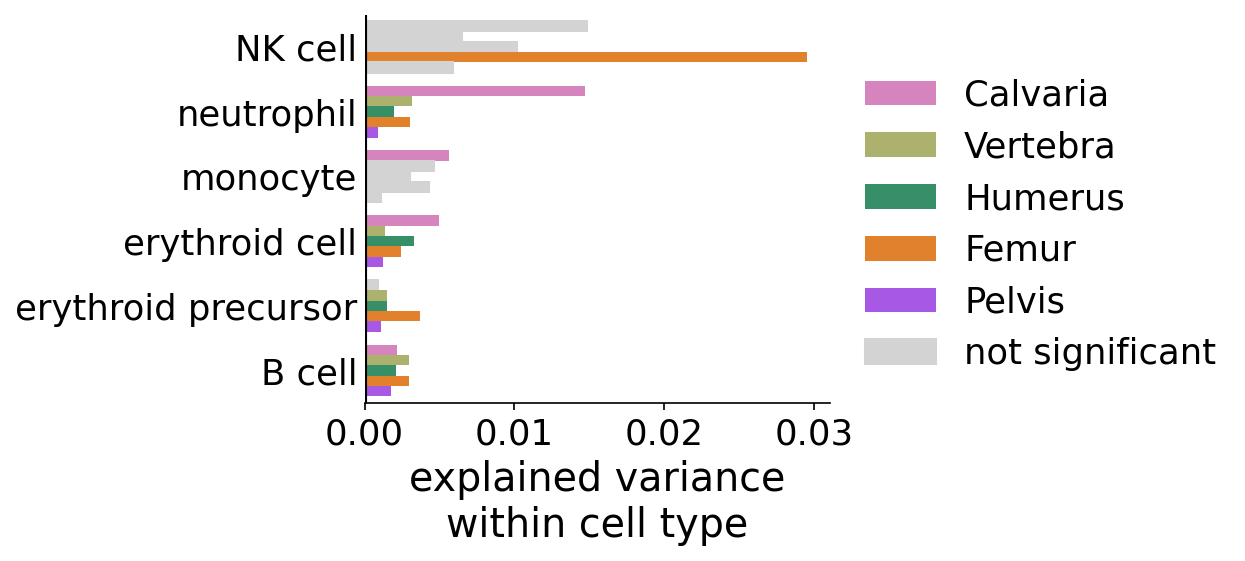

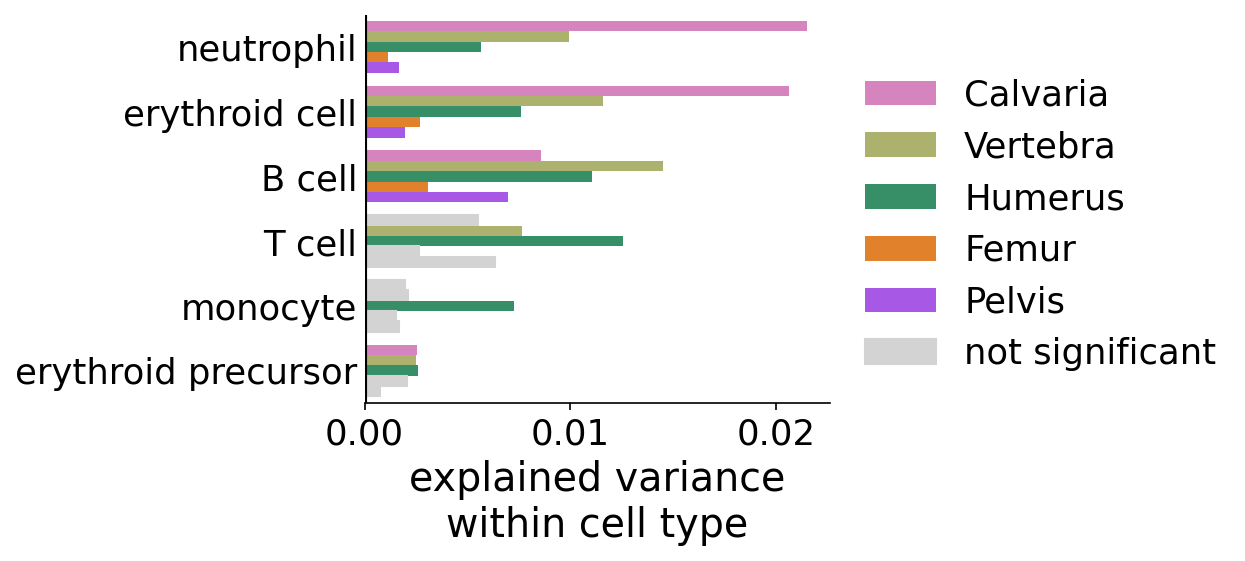

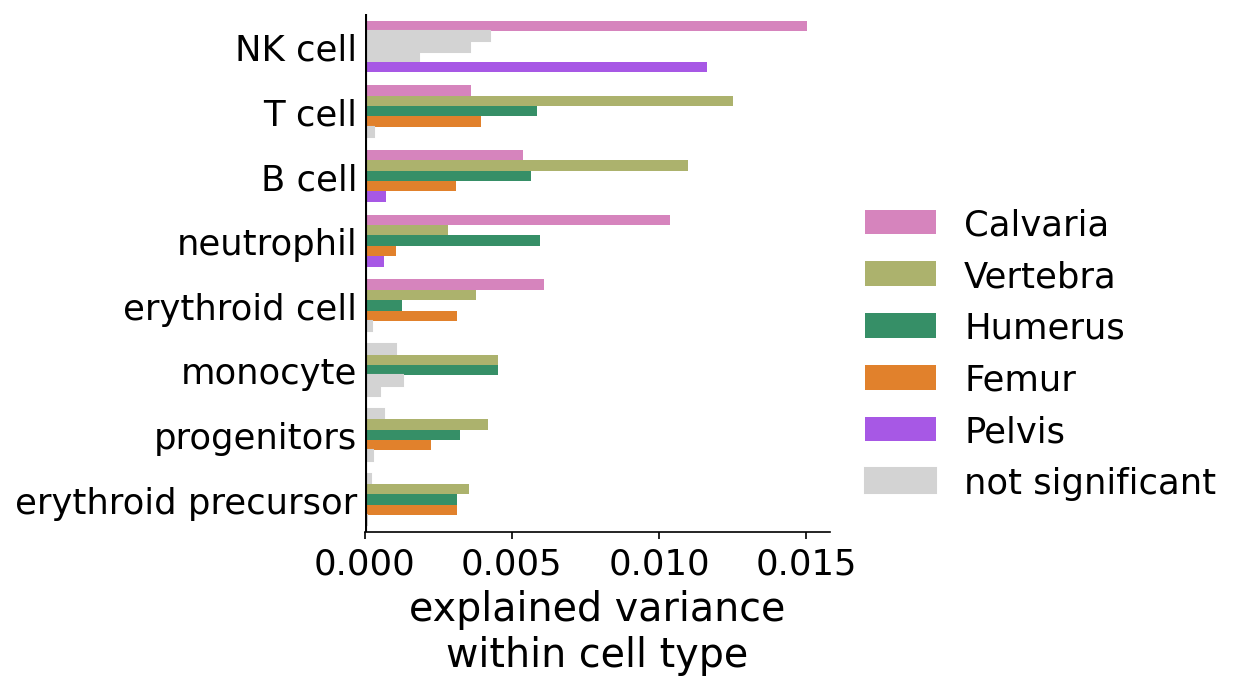

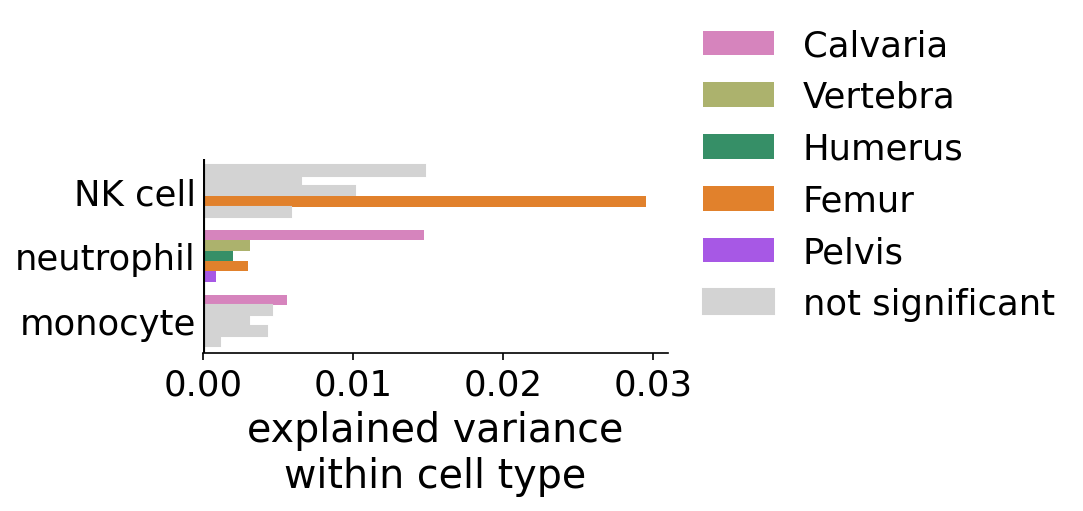

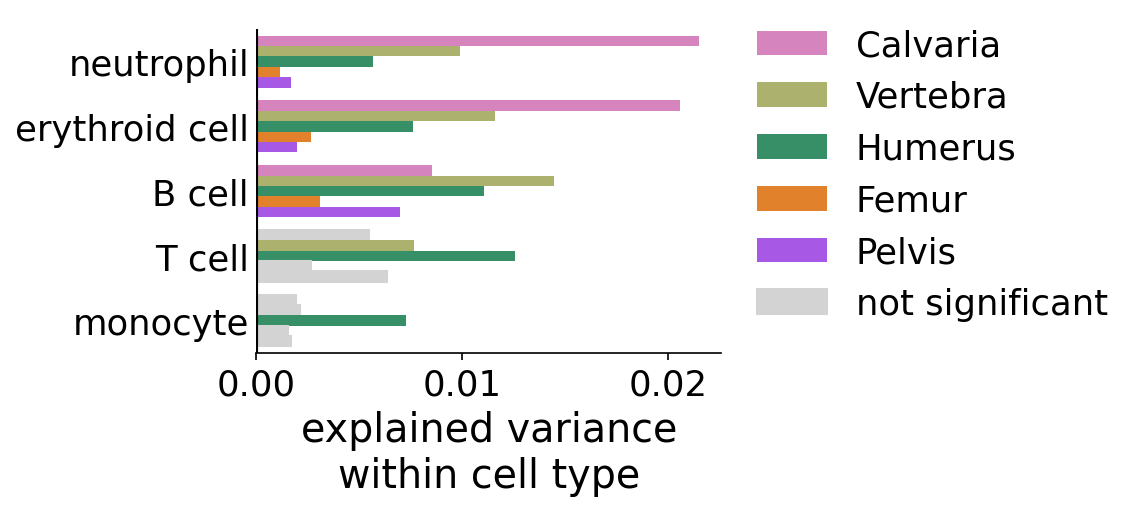

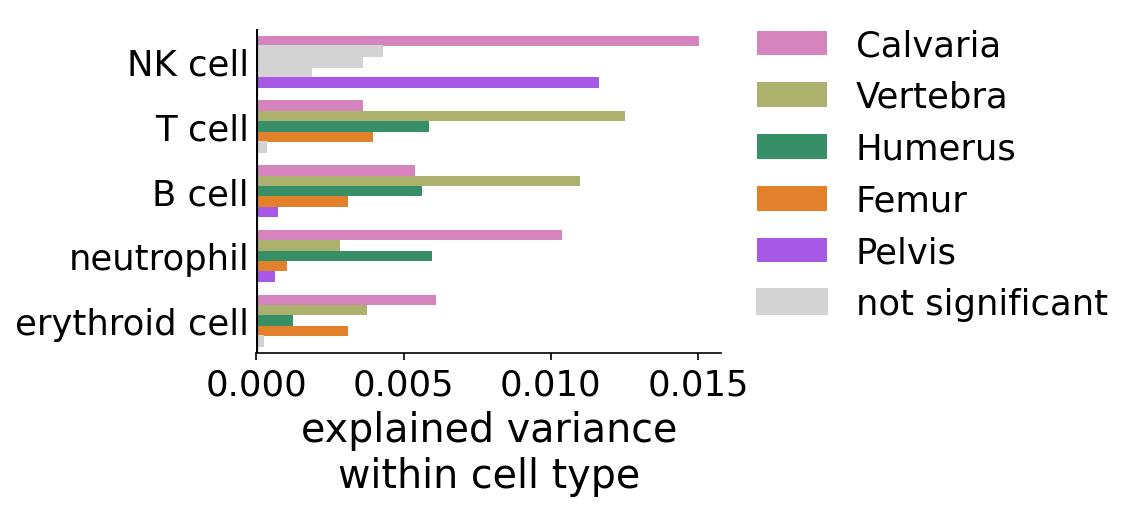

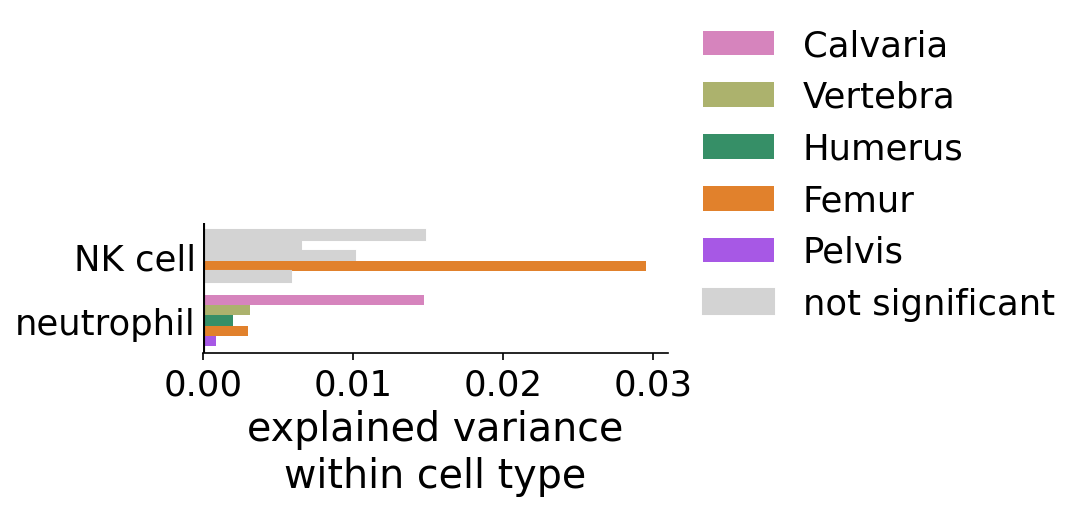

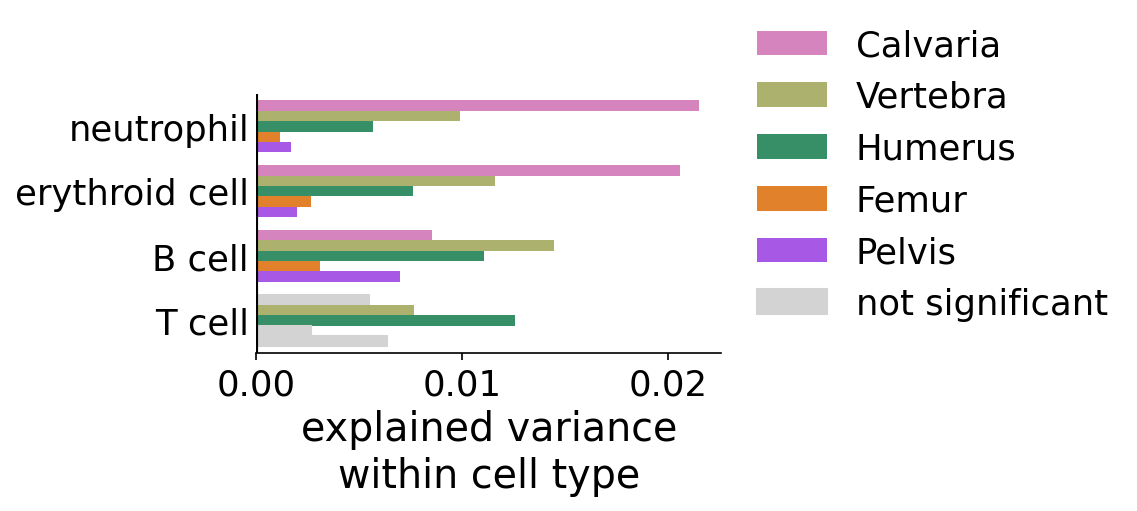

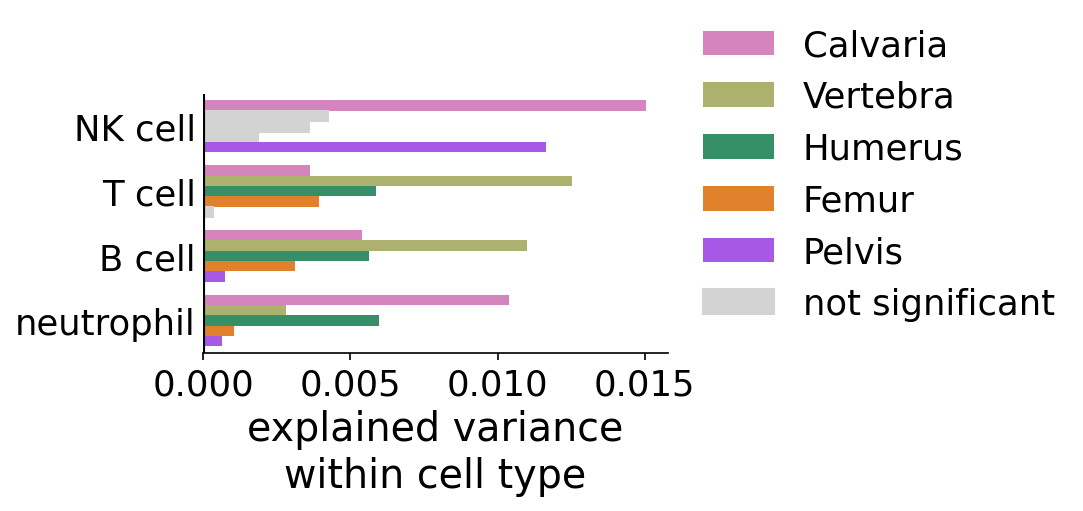

In [12]:
pval_th = 0.0001
R2_th = 0.005

for cond in ["Naive","Sham","MCAO"]:
    df = get_region_df(res_dir+"bones_no_scapula/",cts,results_key='cond_subsets',condition=cond,bones_only=True,exclude_nans=True)
    df = filter_celltypes_for_significance(df,pval_th=pval_th)
    bar_plot(
        adata,df,hue='region',
        save=f'./figures/PCR_no_scapula_level1_{cond}_p{pval_th}.pdf',
        order=bones,colors=None,pval_th=pval_th
    )
    
    
for cond in ["Naive","Sham","MCAO"]:
    df = get_region_df(res_dir+"bones_no_scapula/",cts,results_key='cond_subsets',condition=cond,bones_only=True,exclude_nans=True)
    df = filter_celltypes_for_significance(df,pval_th=pval_th)
    df = filter_celltypes_for_R2_th(df,R2_th=R2_th)
    bar_plot(
        adata,df,hue='region',
        save=f'./figures/PCR_no_scapula_level1_{cond}_p{pval_th}_R2th{R2_th}.pdf',
        order=bones,colors=None,pval_th=pval_th
    )    
    
    
R2_th = 0.008
for cond in ["Naive","Sham","MCAO"]:
    df = get_region_df(res_dir+"bones_no_scapula/",cts,results_key='cond_subsets',condition=cond,bones_only=True,exclude_nans=True)
    df = filter_celltypes_for_significance(df,pval_th=pval_th)
    df = filter_celltypes_for_R2_th(df,R2_th=R2_th)
    bar_plot(
        adata,df,hue='region',
        save=f'./figures/PCR_no_scapula_level1_{cond}_p{pval_th}_R2th{R2_th}.pdf',
        order=bones,colors=None,pval_th=pval_th
    )    

## Conditions pooled in one plot

In [13]:
import matplotlib.ticker as ticker

def bar_plot_all_conds(
    adata,df,hue='region',save=None,order=None,y_order=None,
    colors=None,pval_th=0.0001,legend_pos=1.9,cond_pos=-0.80,ct_counts={"Naive":1,"Sham":1,"MCAO":1}
):
    """
    
    df: has columns ['celltype',hue,'score']
    hue: 'condition','region', or sth else - in that case provide order and colors!
    save: path to save plot
    """
    
    assert len(df["score"]) == len(df["score"].unique()), "This assertion is needed to find the correct bars when coloring by pval"
    # if this doesn't hold you could add some epsilon to the similar values
    
    # Rename Skull to Calvaria
    if (hue in adata.obs.columns) and ("Skull" in adata.obs[hue].cat.categories):
        adata.obs[hue].cat.rename_categories({'Skull': 'Calvaria'}, inplace=True)
    if "region" in df.columns:
        df.loc[df["region"] == "Skull","region"] = "Calvaria"
    if order is not None:
        order = ["Calvaria" if r=="Skull" else r for r in order]
    
    #try:
    if hue in ['condition','region']:
        if order is None:
            order = adata.obs[hue].cat.categories.values
        if colors is None:
            colors = adata.uns[f'{hue}_colors'][[adata.obs[hue].cat.categories.values.tolist().index(o) for o in order]]
    
    df['max'] = df[['score']].max(axis=1)
    df = df.sort_values('max', ascending=False)    
    
    div_factor = 2.5 - 0.15*len(df[hue].unique())
    f, ax = plt.subplots(figsize = (4,len(df["celltype"].unique())/div_factor))#(5,len(df["celltype"].unique())/2))
    bp = sns.barplot(x = 'score', y = 'celltype', hue=hue, hue_order=order, data = df, order=y_order,
                 edgecolor = None,#edgecolor = 'w',
                palette=colors) #, color = 'black' label = 'Total',
    plt.axvline(x=0,c='black')
    plt.xlabel('explained variance\nwithin cell type')
    plt.ylabel('')
    ax.legend(loc='lower left', bbox_to_anchor=(1, 0),frameon=False)
    #plt.legend(frameon=False,loc='lower right')
    sns.despine(left = True)#, bottom = True)
    ax.tick_params(axis='y', which='both',length=0)
    
    handles, labels = bp.get_legend_handles_labels()
    patch = patches.Patch(color='lightgray', label='not significant')
    handles.append(patch) 
    plt.legend(handles=handles,frameon=False, loc='lower right', bbox_to_anchor=(legend_pos,0))
    
    for bar in bp.patches:
        pval = df.loc[(df["score"] == bar._width).idxmax(),"pval"]
        if pval > pval_th:
            bar.set_color('lightgray')        
    
    
    # Second Y-axis
    ax2 = ax.twinx()
    
    ax2.spines["left"].set_position(("axes", cond_pos))
    ax2.tick_params('both', length=0, width=0, which='minor')
    ax2.tick_params('both', direction='in', which='major')
    ax2.yaxis.set_ticks_position("left")
    ax2.yaxis.set_label_position("left")
    
    
    n_ct_labels = ct_counts["Naive"] + ct_counts["Sham"] + ct_counts["MCAO"]
    yticks = [1.0]
    for _,count in ct_counts.items():
        yticks.append(yticks[-1] - count/n_ct_labels)
    ticklabel_pos = [(yticks[i]+yticks[i+1])/2 for i in range(len(yticks)-1)]
    
    ax2.set_yticks(yticks)#[0.0, 0.6, 1.0])
    ax2.yaxis.set_major_formatter(ticker.NullFormatter())
    ax2.yaxis.set_minor_locator(ticker.FixedLocator(ticklabel_pos))#[0.3, 0.8]))
    ax2.yaxis.set_minor_formatter(ticker.FixedFormatter([key for key in ct_counts]))
    #ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, ha='center', va='center')
    plt.setp(ax2.yaxis.get_minorticklabels(), rotation=90, va="center")
    #print(ax2.get_yticklabels())
    #ax2.tick_params(axis="y", which="both", rotation=90)#, ha='center')
    
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    #return bp        
    
    plt.show()
    
    if save:
        # f'./figures/PCR/PCR_all_conditions_per_region_{group}.pdf'
        f.savefig(save, bbox_inches = "tight")  
    #except:
    #    print("Couldn't plot for df:")
    #    display(df)
    


def get_cond_pooled_df(pval_th=0.0001,R2_th=False):
    """
    """
    dfs = []
    for cond in ["Naive","Sham","MCAO"]:
        df = get_region_df(res_dir+"bones_no_scapula/",cts,results_key='cond_subsets',condition=cond,bones_only=True,exclude_nans=True)
        df = filter_celltypes_for_significance(df,pval_th=pval_th)
        if R2_th:
            df = filter_celltypes_for_R2_th(df,R2_th=R2_th)
        df["condition"] = cond
        dfs.append(df)
    df = pd.concat(dfs)
    ct_order = get_ct_order(df)
    ct_order+= [" "+ct for ct in ct_order] + ["  "+ct for ct in ct_order]
    
    ct_counts = {"Naive":0,"Sham":0,"MCAO":0}
    for ct in df["celltype"].unique():
        for cond in ["Naive","Sham","MCAO"]:
            if ct in df.loc[df["condition"]==cond,"celltype"].values:
                ct_counts[cond] += 1
    
    df.loc[df["condition"]=="Sham","celltype"] = " " + df.loc[df["condition"]=="Sham","celltype"]
    df.loc[df["condition"]=="MCAO","celltype"] = "  " + df.loc[df["condition"]=="MCAO","celltype"]
    ct_order = [ct for ct in ct_order if ct in df["celltype"].values]
    df = df.reset_index(drop=True)    

    return df,ct_order,ct_counts


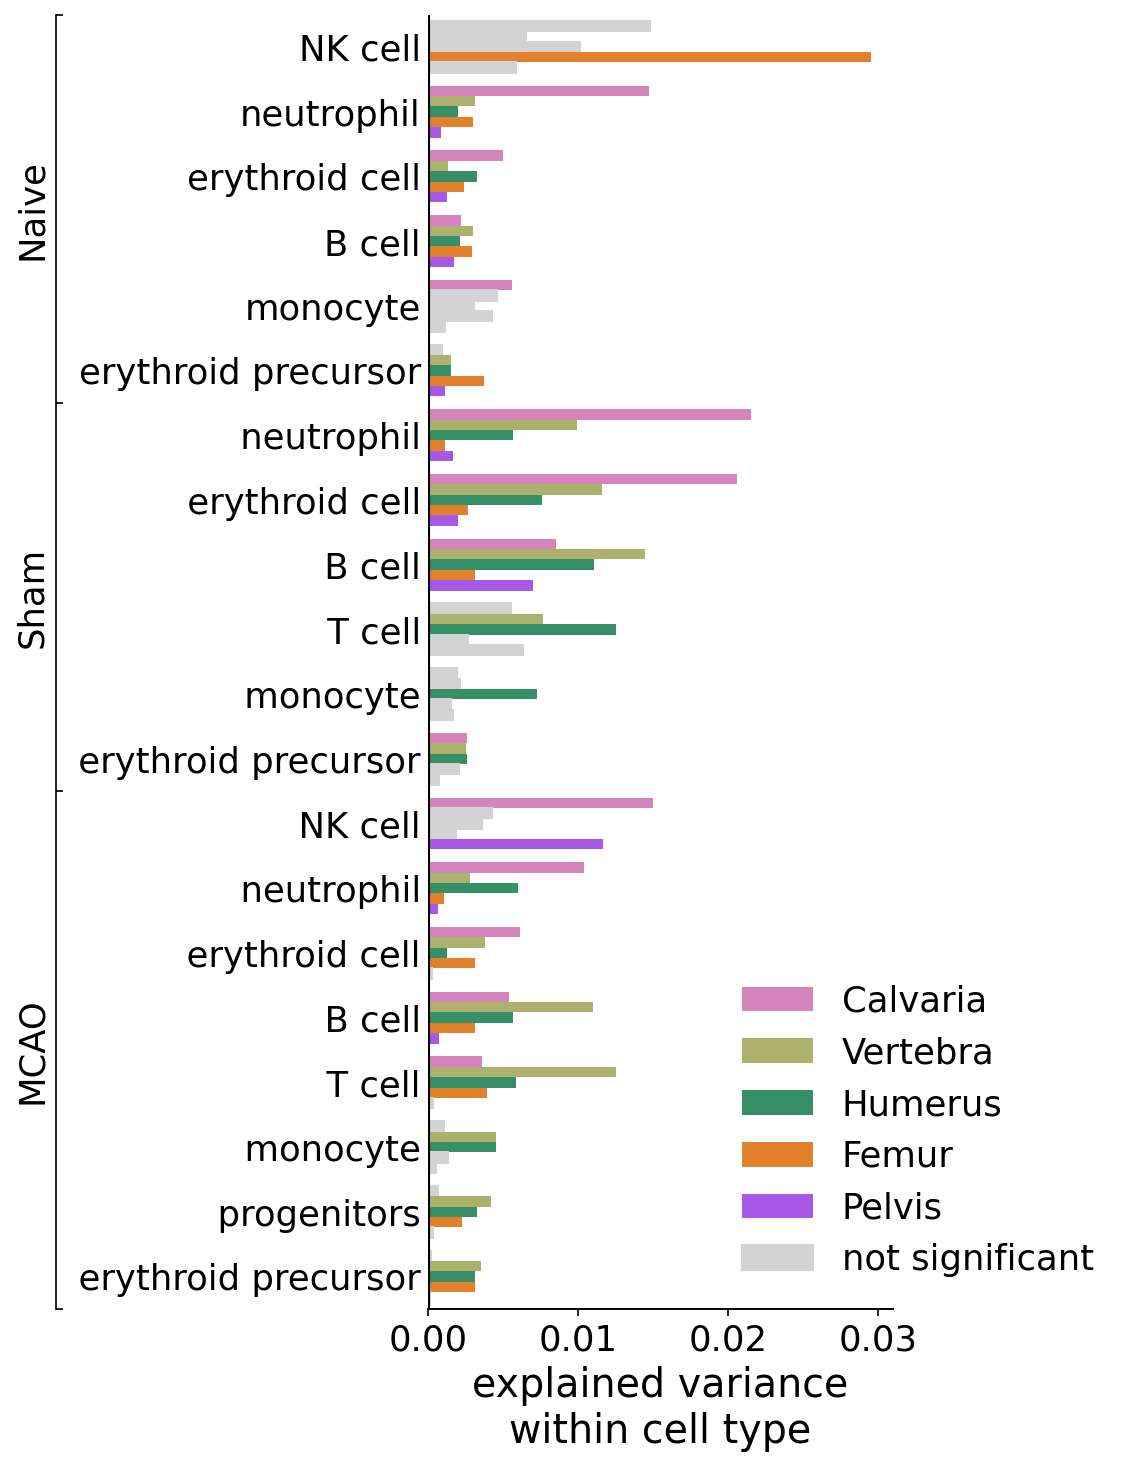

In [14]:
pval_th = 0.0001
R2_th = False
df,ct_order,ct_counts = get_cond_pooled_df(pval_th=pval_th,R2_th=R2_th)

bp = bar_plot_all_conds(
    adata,df,hue='region',y_order=ct_order,
    save=f'./figures/PCR_no_scapula_level1_all_conditions_p{pval_th}.pdf',
    order=bones,colors=None,pval_th=pval_th,ct_counts=ct_counts,legend_pos=1.5,cond_pos=-0.80
)

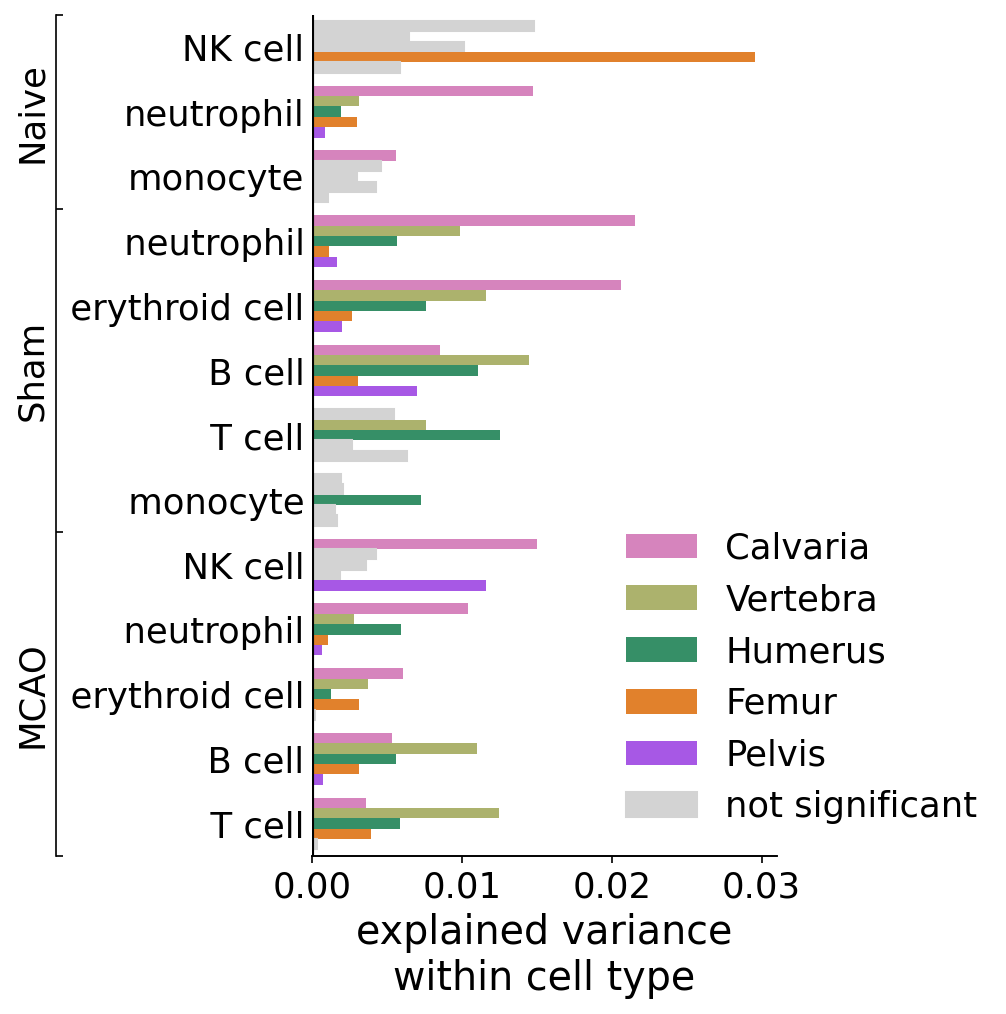

In [15]:
pval_th = 0.0001
R2_th = 0.005
df,ct_order,ct_counts = get_cond_pooled_df(pval_th=pval_th,R2_th=R2_th)

bp = bar_plot_all_conds(
    adata,df,hue='region',y_order=ct_order,
    save=f'./figures/PCR_no_scapula_level1_all_conditions_p{pval_th}_R2th{R2_th}.pdf',
    order=bones,colors=None,pval_th=pval_th,ct_counts=ct_counts,legend_pos=1.5,cond_pos=-0.55
)

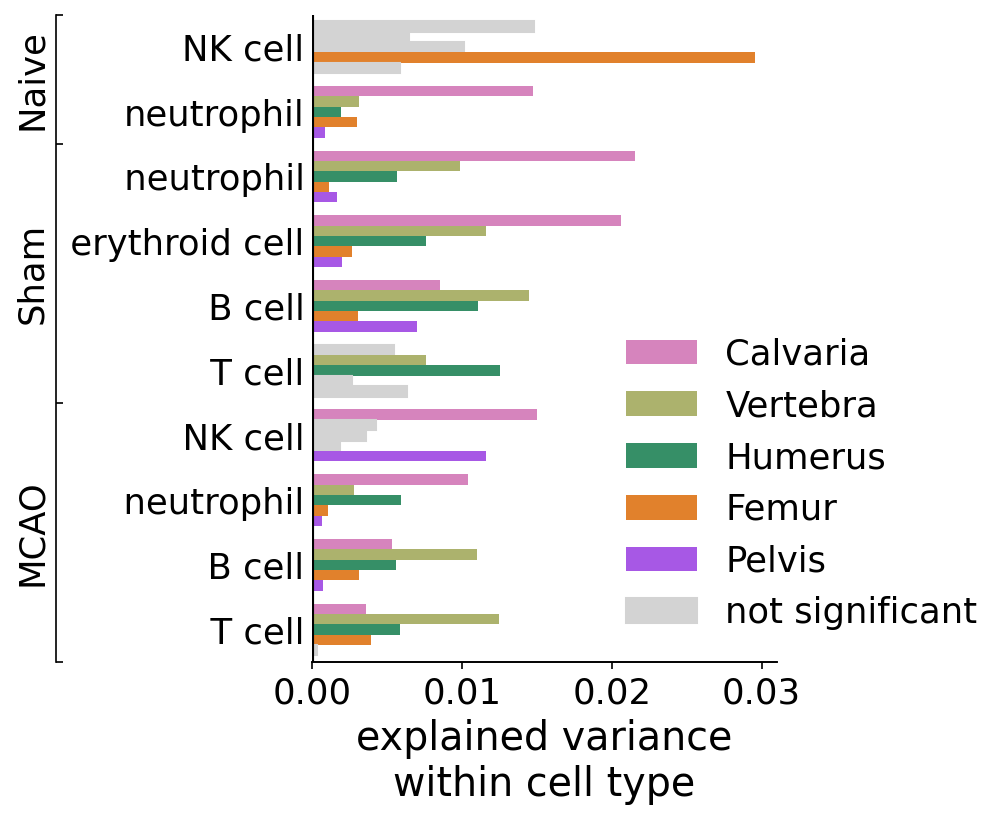

In [16]:
pval_th = 0.0001
R2_th = 0.008
df,ct_order,ct_counts = get_cond_pooled_df(pval_th=pval_th,R2_th=R2_th)

bp = bar_plot_all_conds(
    adata,df,hue='region',y_order=ct_order,
    save=f'./figures/PCR_no_scapula_level1_all_conditions_p{pval_th}_R2th{R2_th}.pdf',
    order=bones,colors=None,pval_th=pval_th,ct_counts=ct_counts,legend_pos=1.5,cond_pos=-0.55
)